## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

This notebook builds the predictive model as described in the project brief. It details the process involved in producing the model through explanation of the model choice, following evaluation of its accuracy and comparison with other models.

There are a number of steps involved in creating an accurate predictive model. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

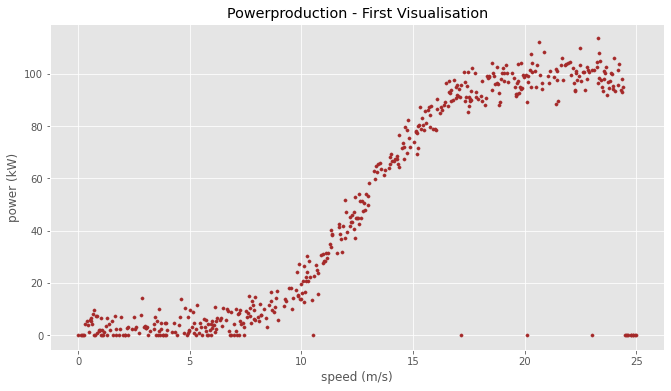

In [5]:
# Plot data on a scatter plot
plt.title('Powerproduction - First Visualisation')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o', s=10)

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

**note:** *I have assigned the above units of measurement to each variable, kilowatts (kW) for power and meters-per-second (m/s) for wind speed. This makes the explanations throughout the project clearer. These units were deduced following a quick Google search*

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

The term *Function approximation* describes the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to detect any outliers in order to improve the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.

#### 3.1 Outliers

When training a predictive model, it is important to remove any outliers so that the data we train the model on fully represents the observed data. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13].

Prior to removing any identified outliers, let us first see how a simple linear regression (SLR) model performs with the orignial data set. The data is split into training and testing data. This procedure is explored and explained in greater detail below:

In [6]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Generate instance of the LinearRegression class to create model
reg_pp = LinearRegression()

# Call the fit method to train model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value for evaluation
score_pp = reg_pp.score(A_Test_pp, B_Test_pp)

# Print score
print(score_pp)

0.7196585822445968


Training the model using the full data set yields a score of **~0.72**. This represents the R-Squared value also known as the *coefficient of determination* [23]. The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1, while a score of 0 generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].

The trained model is then used to make predictions based on the test data. We can use this prediction to plot a line to visualise how well it fits.

<br>

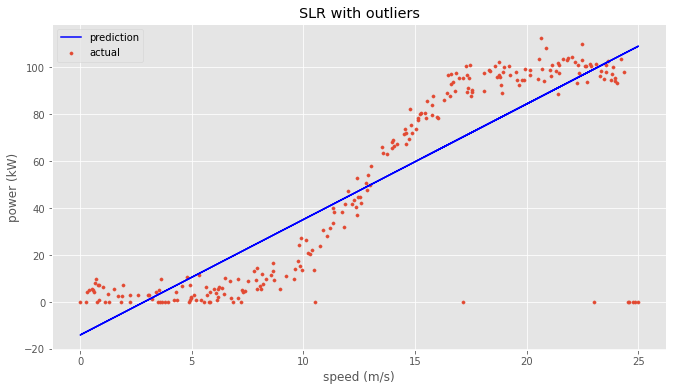

In [7]:
# Use model to make predictions
pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('SLR with outliers')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

Here we can visualise the output predicted by the model from the test data, plotted as a straight line against the scatter plot of both variables. It quite clearly does not accurately fit the data. 

#### 3.1.2 Outlier detection and removal

As mentioned above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appear to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. It returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [8]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [9]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed on the scatterplot. Building on the preliminary analysis above, we can see from the data set that the final ten observations have power values of 0kW. Wind speeds of >25.499 do not produce any power, which implies perhaps that the turbine is incapable of generating power above this value. It is reasonable to assume that this is the cut-out speed, where "... the turbine shuts down to avoid damage" [27] and is a common characteristic of wind turbines [28]. Let's take a look at the bottom 20 rows of the original data set to see if this sudden drop-off in power production can be seen from the observations:

In [10]:
# Output bottom 20 rows
pp.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


It appears evident that wind speeds above ~24.499 do not produce any power. This should be reflected in our final model. For now, they will be removed from the data set so that the model can be more accurately trained to predict power values for wind speeds below the cut-out. This characteristic will be handled once the model has been trained.

Below, I remove them from the data set, creating an updated data set `pp_updated` in the process:

In [11]:
# Remove outliers from data set
pp_updated = pp.drop(outliers_mahal_rob)

In [12]:
# Output statistical summary of updated data frame
pp_updated.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


Text(0, 0.5, 'power (kW)')

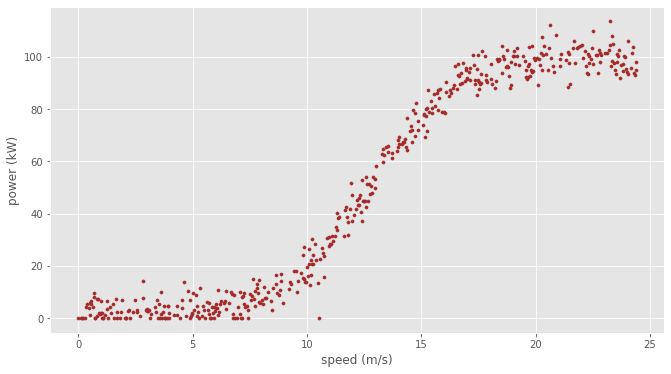

In [13]:
plt.scatter(pp_updated['speed'], pp_updated['power'], color='brown', marker='o', s=10)
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')

The Mahalonibis Distance function detected all but one outlier. I will remove this too for improved performance. Firstly, we view the last 5 observations with power = 0kW:


In [14]:
pp_zero = pp_updated.loc[pp_updated['power'] == 0]
pp_zero.tail()

,speed,power
135,6.857,0.0
136,6.957,0.0
140,7.107,0.0
149,7.432,0.0
208,10.511,0.0


We can see that the outlier is at index 208. This can be removed with the following code:

In [15]:
pp_clean = pp_updated.drop([208])

Now we can train the model with the updated data set:

In [16]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(pp_clean.speed, pp_clean.power, test_size = 0.5, random_state=1)

# Convert to numpy arrays and reshape
reg_speed_train = x_train.to_numpy().reshape(-1, 1)
reg_power_train = y_train.to_numpy().reshape(-1, 1)
reg_speed_test  = x_test.to_numpy().reshape(-1, 1)
reg_power_test = y_test.to_numpy().reshape(-1, 1)


# Create model
reg_pp_clean = LinearRegression()

# Fit model
reg_pp_clean.fit(reg_speed_train, reg_power_train)

# Calculate R-squared value
score_pp_clean = reg_pp_clean.score(reg_speed_test, reg_power_test)

# Print score
print(score_pp_clean)

0.9008406364589567


Once the outliers are removed, the model performs better. It yields a score of **~0.90**. 

<br>

We can plot both models side by side for visual comparison:

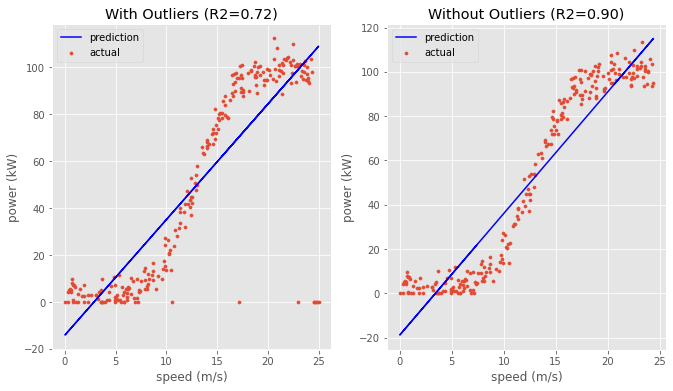

In [17]:
# First subplot
plt.subplot(1, 2, 1)
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('With Outliers (R2=0.72)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)

# Call predict method on test data and plot resulting line
pp_updated_predict = reg_pp_clean.predict(reg_speed_test)

plt.scatter(reg_speed_test, reg_power_test, label='actual', s=10)
plt.plot(reg_speed_test, pp_updated_predict, label='prediction', color='b')

plt.title('Without Outliers (R2=0.90)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

When viewed side by side, we see that once the outliers are removed the line is a slightly better fit, although it is clear that a straight line does not manage to capture the data accurately in either model.

<br>

#### 3.1.3 Train-test split

This section provides a brief explanation of the *train-test split* procedure as performed in the previous section.

In machine learning, *evaluation* and *validation* are key aspects in measuring how well a model is performing [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 


<br>

First, the `pp_clean` data set is split by column into two separate subsets, one containing each variable. :

In [18]:
# Create a new dataset containing only values from the speed column
speed_df = pp_clean.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [19]:
# Create a new dataset containing only values from the power column
power_df = pp_clean.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

**Note: The code below is an exact copy of the procedure as performed above. This is just for demonstration purposes**

In [20]:
# Call train_test_split method on dataframes
x_train, x_test, y_train, y_test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)

<br>



## 4. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` class will be used to apply a model to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created.


<br>

### 4.1 Simple linear regression

***

In demonstrating the importance of outlier removal above, I used simple linear regression models. This section provides a brief explanation of simple linear regression before exploring polynomial regression to create a predictive model.

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> It can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set. 

Once the outliers were removed, the model as trained on the training data produced a score of ~0.90. For certain predictive models, an R-squared value of ~0.90 might be considered satisfactory. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.


<br>

### 4.2 Polynomial regression

***

Visualising the plots above, we can see that a straight line does not fit the data accurately. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the *degree* parameter to the desired power. Then, this model can be trained using the `LinearRegression` class just as above. The code for this is based on an informative *towardsdatascience.com* blog post [28].

First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fit to the model and predictions are made based on the test data. 

In [21]:
# Convert train and test subsets to numpy arrays
poly_speed_train = x_train.to_numpy().reshape(-1, 1)
poly_power_train = y_train.to_numpy().reshape(-1, 1)
poly_speed_test  = x_test.to_numpy().reshape(-1, 1)
poly_power_test = y_test.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

<br>

Using `sciki-learn`'s evaluation metrics, we can calculate the R-squared value as well as the *mean-squared-error* (mse), which is the most commonly used regression loss function [29]:

In [22]:
# Calculate mean squared error 
mse = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2 = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse, r2

(18.29934798625694, 0.9895079443988561)

With an R-Squared value of **~0.99** we can see that polynomial regression performs significantly better than the simple linear regression models above. The mse is **~18.29**. This will be compared with additional models below.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely than simple linear regression:

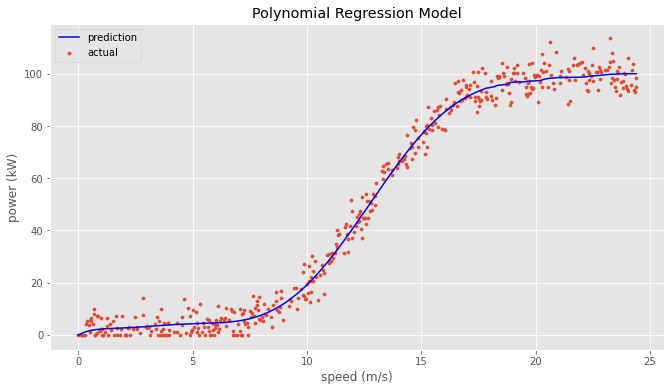

In [26]:
# Plot on scatterplot
plt.scatter(pp_clean.speed, pp_clean.power, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.title('Polynomial Regression Model')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

## 5. Neural network - Regression with `keras`

***

Neural networks is one of the most commonly used algorithms in machine learning and it covers a broad range of concepts and techniques [30]. Below, I build a neural network which implements regression to predict wind turbine power output from wind speed input. Depending on the nature of the problem to be solved, neural networks can range from simple, with fewer hidden layers (shallower) and fewer neurons in each layer (narrower), to more complex structures (deeper and wider) [31]. 


#### 5.1 Setting parameters
When applying a neural network model to a problem, there are a number of such parameters which can be tuned/set which can minimize the loss function. For the purposes of the current project, I do not make many major tuning adjustments. However, below I give a brief overview of the parameters involved, taking in some key concepts of neural networks in the process:

* **Number of hidden layers**: Adding/removing hidden layers can impact the performance of a neural network
* **Number of neurons**: Increasing/decreasing the number of neurons in a given layer can also minimize the loss function
* **Number of epochs**: When training a model with input data, the algorithm iterates through epochs (cycles). Depending on the data set, a model may need to run through few or many epochs to minimize the loss function sufficiently [32].
* **Batch size**: This refers to the number of training samples the applied to the algorithm before the model's internal parameters are updated [33]
* **Weight parameter**: The neurons in each layer are connected to each previous and subsequent layer, with each connection assigned a weight. For the neural networks created using Keras, this parameter can be set via the `kernal_initializer` parameter. For the models below I use built-in initializers. In the first step of a neural network, the input value is multiplied by its corresponding weight and this is repeated for each input value and added together (dot product between inputs and weights) [34]
* **Bias**: The bias is added to the dot product between inputs and weights. It "... is necessary to make a robust neural network" [35]. Like the weight parameter, the bias can be assigned with the `bias_initializer` parameter in each layer. The bias can ensure, for example, that the dot product will never return a value of zero, which would happen if the input values were zero in a given data set. Adding the bias term is a convention when building neural networks and is often set to 1 as default e.g. in the case described. This calculation can be represented mathematically as: 
<br>

$$f \left( b + \sum_{i=1}^{n}x_iw_i \right)$$ 

<br>

* **Activation function**: The value from this calculation is then passed through an activation function. The activation function essentially predicts the output from for the input features [36]. The `activation` parameter to any one of a range of functions as provided by the `keras` library (although the function itself cannot be altered). The default is a linear function which will be used for the output layer for the models below. The sigmoid and relu activation functions will be used in the hidden layers and compared in order to minimise the loss function. 
* **Loss function**: The loss function calculates the error between the predicted and observed output. Its value gives us an indication as to how well our model is performing. When training any predictive model, minimisation of the loss function can be seen as the goal to aim for. For the models below, I will apply MSE (*mean squared error*). This is a commonly used loss function for regression problems and can be expressed mathematically as: 

<br>

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(predicted - observed)^2$$

   where $n$ = numer of observations [37]
* **Optimization algorithm**: The aim of the optimization algorithm is to minimize the loss function. `Keras` provides a range of optimizers. Below, I use the the *Adam* function in all models.

<br>



#### 5.2 K-fold cross validation

***

As described above, the train-test-split procedure is used to ensure model evaluation yields unbiased results. However, it is not always easy to decide which portion of the data to split into test and train subsets. In addition, because the `train_test_split()` function randomly selects the data points for each subset, re-running the code will inevitably produce different evaluation metric scores. The *random_state* parameter does enable reproducibility, however this does not allow for different data point combinations to fully train and test the model.

K-fold cross validation is a statistical method commonly used in machine learning to evaluate the skill of a predictive model. It operates similarly to the train-test-split procedure, but involves training and testing a greater number of subsets of the data sample. As a result, evaluation with cross validation represents a less biased estimate of the skill of the model [38]. 

Cross validation also allows us to compare machine learning models. Using k-fold cross validation below, I compare neural network models based on skill estimates of each model. Altering the number of neurons in the hidden layer, changing the activation function and number of epochs, we see that the performance of the models is impacted. The basis for the code used is from a *machinelearningmastery.com* blog post [39].

<br>

#### 5.3 Build and compare neural netwok models

The first model contains one hidden layer with 10 neurons and uses the *relu* activation function. The Adam optimizer has a *learning rate* of 0.01. The model is evaluated using kfold validation and the mean squred error calculated with `scikit-learn`'s `cross_val_score` function. 

In [38]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values

# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]


def model1():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(10, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model


# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=model1, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results1 = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4911.5155
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 4034.5545
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 2418.9742
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 758.0445
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 149.6189
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 122.3055
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 114.6012
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 117.7821
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 112.3049
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 92.3217
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 111.4291
Epoch 12/100
44/44 [==============================] - 0s 2ms/step - loss: 88.4342
Epoch 13/100

5/5 [==============================] - 0s 4ms/step - loss: 150.7139
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4632.7359
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 4288.2648
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 2739.2867
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 1193.2030
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 383.9084
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 162.2905
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 136.4956
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 130.8900
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 124.6718 0s - loss: 116.54
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 121.1285
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 118.6052
Epoch 

Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 35.4279
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 38.8879
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 15.5834
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4659.5559
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 4006.9791
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 2687.7207
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 1351.0233
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 389.5979
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 145.2939
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 133.8233
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 130.3040
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 117.5045
Epoch 10/100


44/44 [==============================] - 0s 2ms/step - loss: 32.9617
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 35.5290
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 34.0054
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 35.1923
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 49.9242
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4401.5961
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 4489.5291
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 3392.5476
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 2128.4489
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 1182.4346
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 420.0681
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 183.0050
Epoch 8/100
44/44 [======

44/44 [==============================] - 0s 2ms/step - loss: 43.6329
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 45.5197
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 39.2438
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 48.2391
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 44.4606
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 39.5108
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 67.2090
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4875.7807
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 4218.0778
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 3181.6800
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 1822.9250
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 697.8422
Epoch 6/100
44/44 [=======

44/44 [==============================] - 0s 2ms/step - loss: 118.5719
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 137.1444
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 118.8158
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 109.0000
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 129.0315
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 122.9760
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 118.4897
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 135.6391
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 114.8817
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 99.5778
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4013.7551
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 3809.8851
Epoch 3/100
44/44 [

44/44 [==============================] - 0s 2ms/step - loss: 121.3473
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 124.8114
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 125.4506
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 115.3360
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 123.2554
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 106.4435
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 131.5370
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 111.5565
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 118.3218
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 121.2609
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 116.4620
Epoch 100/100
5/5 [==============================] - 0s 0s/step - loss: 130.3131
Epoch 1/100
44/44 [

44/44 [==============================] - 0s 2ms/step - loss: 50.9412
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 50.0209
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 47.4604
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 48.3363
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 50.7750
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 41.8568
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 46.5721
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 45.6959
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 42.4661
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 47.0948
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 51.2979
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 48.6214
Epoch 100/100
5/5 [==========

44/44 [==============================] - 0s 2ms/step - loss: 115.8428
Epoch 87/100
44/44 [==============================] - 0s 2ms/step - loss: 116.6209
Epoch 88/100
44/44 [==============================] - 0s 2ms/step - loss: 106.1898
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 109.0272
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 115.8329
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 117.6818
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 108.3796
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 119.9938
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 112.2632
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 117.1712
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 121.2892
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 111.3705
Epoch 98/100
44/4

44/44 [==============================] - 0s 3ms/step - loss: 42.4413
Epoch 85/100
44/44 [==============================] - 0s 2ms/step - loss: 44.2864
Epoch 86/100
44/44 [==============================] - 0s 2ms/step - loss: 38.1793
Epoch 87/100
44/44 [==============================] - 0s 2ms/step - loss: 48.8168
Epoch 88/100
44/44 [==============================] - 0s 2ms/step - loss: 43.1862
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 46.2336
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 45.2928
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 41.4938
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 44.7545
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 42.2984
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 37.3191
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 37.1027
Epoch 96/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 43.4408
Epoch 84/100
44/44 [==============================] - 0s 2ms/step - loss: 48.3282
Epoch 85/100
44/44 [==============================] - 0s 2ms/step - loss: 40.2686
Epoch 86/100
44/44 [==============================] - 0s 2ms/step - loss: 41.6705
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 41.6579
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 38.5431
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 44.9051
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 43.1562
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 42.1154
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 39.0024
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 42.7693
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 38.7932
Epoch 95/100
44/44 [=========

In [40]:
print("MSE: %.2f" % (results1.mean()))

MSE: -149.36


This model returns a mean squared error of 149.36

<br>

Increasing the number of neurons in the hidden layer from 10 to 100, we can see that the model performs better:

In [43]:
def model2():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=model2, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results2 = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4398.0744
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1714.6842
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 142.5330
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 144.4733
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 130.1132
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 125.2543
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 109.8339
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 104.1275
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 108.2850
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 106.8342
Epoch 11/100
44/44 [==============================] - 0s 3ms/step - loss: 111.2236
Epoch 12/100
44/44 [==============================] - 0s 3ms/step - loss: 92.7525
Epoch 13/100

5/5 [==============================] - 0s 2ms/step - loss: 202.1795
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3954.8217
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1562.6926
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 141.4643
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 129.4611
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 124.7448
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 129.3916
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 110.0704
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 106.8552
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 108.2939
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 101.0917
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 96.3342
Epoch 12/100
44/44 [=======

44/44 [==============================] - 0s 2ms/step - loss: 19.5632
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 22.9177
Epoch 100/100
5/5 [==============================] - 0s 5ms/step - loss: 14.1422
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4242.4432
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1550.5761
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 150.9306
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 115.5734
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 114.3001
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 120.1572
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 114.6022
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 114.7826
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 99.1439
Epoch 10/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 20.2754
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 21.6010
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 19.3030
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 11.7549
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4647.9421
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1942.5283
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 117.6745
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 121.6025
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 123.6798
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 106.1170
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 111.0248
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 104.0726
Epoch 9/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 19.9534
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 19.9822
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 22.4907
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 18.5312
Epoch 100/100
5/5 [==============================] - 0s 2ms/step - loss: 17.6948
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4170.9408
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1551.7553
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 136.4453
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 121.6302
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 110.0190
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 115.5790
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 107.1685
Epoch 8/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 33.4757
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 30.0802
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 29.0535
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 34.3594
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 29.6488
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 34.9369
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 66.0792
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3953.2602
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1207.7055
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 141.7893
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 129.2786
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 135.6257
Epoch 6/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 19.8446
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 19.4901
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 18.4989
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 21.6719
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 19.9800
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 20.3058
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 17.9642
Epoch 100/100
5/5 [==============================] - 0s 2ms/step - loss: 17.1058
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3277.8855
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 741.7352
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 110.6256
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 101.3483
Epoch 5/100
44/44 [==========

44/44 [==============================] - 0s 2ms/step - loss: 20.7127
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 21.0880
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 20.0440
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 21.5282
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 19.6910
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 19.8826
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 20.7132
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 21.8308
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 18.2088
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3539.1054
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1115.0999
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 131.8577
Epoch 4/100
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 18.3552
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 20.3772
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 17.9105
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 20.1364
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 18.8996
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 15.5542
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 19.5911
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 15.5525
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 21.4910
Epoch 100/100
5/5 [==============================] - 0s 5ms/step - loss: 21.9566
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3240.2626
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1216.5317
Epoch 3/100
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 17.6941
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 20.4934
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 17.9564
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 19.2736
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 20.0302
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 18.4759
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 17.4931
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 19.5421
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 17.2642
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.9727
Epoch 100/100
5/5 [==============================] - 0s 2ms/step - loss: 24.9568
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3090.2360
Epoch 2/100
44/44 [==========

Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 17.8556
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 16.9351
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 19.8250
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 19.0709
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 17.8964
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 20.0431
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 16.7690
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 18.6489
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 17.3567
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 20.5761
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 18.5460
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 41.8696


In [44]:
print("MSE: %.2f" % (results2.mean()))

MSE: -43.59


With a score of 43.59, we can see that the number of neurons in the hidden layer results in a more skillful model. However, this is still higher than the MSE score from the polynomial regression model above.

Setting the activation function to sigmoid and increasing the number of epochs to 300 builds a more accurate model:

In [64]:
def model3():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    #model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=model3, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results3 = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4164.0372
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 1906.9462
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 681.0557
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 293.1465
Epoch 5/300
44/44 [==============================] - 0s 2ms/step - loss: 157.3263
Epoch 6/300
44/44 [==============================] - 0s 2ms/step - loss: 89.8663
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 70.4742
Epoch 8/300
44/44 [==============================] - 0s 2ms/step - loss: 52.2449
Epoch 9/300
44/44 [==============================] - 0s 3ms/step - loss: 45.3759
Epoch 10/300
44/44 [==============================] - 0s 2ms/step - loss: 34.2650
Epoch 11/300
44/44 [==============================] - 0s 3ms/step - loss: 42.9914
Epoch 12/300
44/44 [==============================] - 0s 2ms/step - loss: 37.7895
Epoch 13/300
44/44

44/44 [==============================] - 0s 3ms/step - loss: 20.5020
Epoch 101/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5845
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2783
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3316
Epoch 104/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1475
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4147
Epoch 106/300
44/44 [==============================] - 0s 3ms/step - loss: 19.1902
Epoch 107/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2089
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8324
Epoch 109/300
44/44 [==============================] - 0s 2ms/step - loss: 21.2731
Epoch 110/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7228
Epoch 111/300
44/44 [==============================] - 0s 2ms/step - loss: 21.7866
Epoch 112/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 20.7365
Epoch 199/300
44/44 [==============================] - 0s 3ms/step - loss: 22.9876
Epoch 200/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2497
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0797
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5009
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4722
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2440
Epoch 205/300
44/44 [==============================] - 0s 2ms/step - loss: 21.9940
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2191
Epoch 207/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8006
Epoch 208/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5085
Epoch 209/300
44/44 [==============================] - 0s 3ms/step - loss: 18.7995
Epoch 210/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 20.3541
Epoch 297/300
44/44 [==============================] - 0s 3ms/step - loss: 23.1007
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4560
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9403
Epoch 300/300
5/5 [==============================] - 0s 4ms/step - loss: 7.8974
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 3991.4241
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 1809.4687
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 662.3787
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 334.3119
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 196.2193
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 107.3258
Epoch 7/300
44/44 [==============================] - 0s 3ms/step - loss: 84.1001
Epoch 8/300
44/44 [========

44/44 [==============================] - 0s 2ms/step - loss: 20.2046
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9285
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1853
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6315
Epoch 98/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5914
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2783
Epoch 100/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9794
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9599
Epoch 102/300
44/44 [==============================] - 0s 3ms/step - loss: 20.0464
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6391
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8294
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9137
Epoch 106/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 20.0162
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7994
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2217
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4295
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 20.5475
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 22.7976
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0469
Epoch 199/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3211
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9741
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2519
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3401
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3877
Epoch 204/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.9506
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4901
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3753
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9389
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3184
Epoch 295/300
44/44 [==============================] - 0s 3ms/step - loss: 20.4875
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8182
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0718
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 21.0827
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0317
Epoch 300/300
5/5 [==============================] - 0s 4ms/step - loss: 13.0794
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4041.3945
Epoch 2/300
44/44 [=

44/44 [==============================] - 0s 2ms/step - loss: 17.0625
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5449
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0075
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2506
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4947
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6220
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9653
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6958
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8906
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2472
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8839
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 21.3716
Epoch 101/300
44/44 [=======

Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 21.0685
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 21.1551
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9799
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3196
Epoch 192/300
44/44 [==============================] - 0s 3ms/step - loss: 17.6465
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8239
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9576
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8743
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3915
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0782
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7880
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7374
Epoc

44/44 [==============================] - 0s 2ms/step - loss: 20.0247
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5031
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5298
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4533
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9198
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9686
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6529
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4749
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7175
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 21.1910
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0530
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 20.5757
Epoch 298/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.5871
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0703
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3646
Epoch 88/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3905
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2152
Epoch 90/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5430
Epoch 91/300
44/44 [==============================] - 0s 3ms/step - loss: 20.3672
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1563
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2675
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 22.8839
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4479
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9580
Epoch 97/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 19.9237
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1718
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4884
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3085
Epoch 188/300
44/44 [==============================] - 0s 3ms/step - loss: 19.2962
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6865
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 22.7470
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2031
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4479
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 21.4198
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1316
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6624
Epoch 196/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.8475
Epoch 283/300
44/44 [==============================] - 0s 3ms/step - loss: 23.0530
Epoch 284/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8286
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2632
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7086
Epoch 287/300
44/44 [==============================] - 0s 3ms/step - loss: 19.4467
Epoch 288/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8988
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9519
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4540
Epoch 291/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8254
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 21.6978
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7446
Epoch 294/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.4841
Epoch 82/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5273
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0923
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2783
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1235
Epoch 86/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5891
Epoch 87/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3228
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1394
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6677
Epoch 90/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7235
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1791
Epoch 92/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3266
Epoch 93/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.7281
Epoch 181/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7289
Epoch 182/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5053
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1082
Epoch 184/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4713
Epoch 185/300
44/44 [==============================] - 0s 3ms/step - loss: 14.9578
Epoch 186/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9427
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0901
Epoch 188/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5752
Epoch 189/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0134
Epoch 190/300
44/44 [==============================] - 0s 3ms/step - loss: 14.5264
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1053
Epoch 192/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.2823
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9767
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0682
Epoch 281/300
44/44 [==============================] - 0s 3ms/step - loss: 14.3438
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0531
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1964
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 14.5656
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7740
Epoch 286/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3199
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6943
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9566
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4593
Epoch 290/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.3231
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 23.3257
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6553
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6740
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1901
Epoch 82/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0239
Epoch 83/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5616
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8061
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1983
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9083
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 21.8017
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6815
Epoch 89/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.8575
Epoch 177/300
44/44 [==============================] - 0s 3ms/step - loss: 22.8441
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1821
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3159
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5433
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5097
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5556
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 19.1926
Epoch 184/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8009
Epoch 185/300
44/44 [==============================] - 0s 3ms/step - loss: 20.7566
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9282
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6206
Epoch 188/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 19.9768
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8973
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4075
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3801
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6931
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0967
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1178
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4520
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8214
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6762
Epoch 284/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3240
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0182
Epoch 286/300
44/4

Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1236
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5496
Epoch 75/300
44/44 [==============================] - 0s 3ms/step - loss: 19.6040
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1735
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3203
Epoch 78/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4930
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8572
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9165
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6511
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 20.0347
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4917
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1811
Epoch 85/300
44/

44/44 [==============================] - 0s 2ms/step - loss: 16.9742
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 21.8005
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9161
Epoch 175/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3609
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5638
Epoch 177/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3781
Epoch 178/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0171
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5809
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1767
Epoch 181/300
44/44 [==============================] - 0s 3ms/step - loss: 20.2527
Epoch 182/300
44/44 [==============================] - 0s 3ms/step - loss: 18.6193
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9468
Epoch 184/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 20.5026
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8678
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2532
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5507
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4069
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8489
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7004
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9588
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 20.8610
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2280
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 22.1965
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0980
Epoch 282/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.4518
Epoch 69/300
44/44 [==============================] - 0s 3ms/step - loss: 19.3051
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7328
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8752
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5394
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5495
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3481
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9541
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9950
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6917
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6860
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8327
Epoch 80/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.5948
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5008
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3812
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4839
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2152
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3500
Epoch 173/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4797
Epoch 174/300
44/44 [==============================] - 0s 3ms/step - loss: 18.8016
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0635
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1511
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9005
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7880
Epoch 179/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.5309
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1724
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7013
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8711
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2576
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6514
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1739
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6864
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7375
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2156
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4202
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 22.4898
Epoch 277/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 22.0880
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2763
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2076
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9135
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5309
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7552
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6644
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 24.0433
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9858
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9119
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8961
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0548
Epoch 75/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.6423
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3411
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4069
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9453
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3465
Epoch 167/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3609
Epoch 168/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5026
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8537
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6155
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4357
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0707
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3863
Epoch 174/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 16.4406
Epoch 261/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9689
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6518
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4090
Epoch 264/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5378
Epoch 265/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4235
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6599
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7606
Epoch 268/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4916
Epoch 269/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4221
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0665
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8102
Epoch 272/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.8145
Epoch 59/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8092
Epoch 60/300
44/44 [==============================] - 0s 3ms/step - loss: 19.4835
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5409
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8152
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 24.6769
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7397
Epoch 65/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5909
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2999
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1682
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9002
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 23.8402
Epoch 70/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.0419
Epoch 158/300
44/44 [==============================] - 0s 3ms/step - loss: 15.2609
Epoch 159/300
44/44 [==============================] - 0s 3ms/step - loss: 19.9477
Epoch 160/300
44/44 [==============================] - 0s 3ms/step - loss: 16.6566
Epoch 161/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3846
Epoch 162/300
44/44 [==============================] - 0s 3ms/step - loss: 19.5399
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7558
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1116
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7245
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9279
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7329
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6466
Epoch 169/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.3013
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6635
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6852
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2852
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6463
Epoch 260/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7023
Epoch 261/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5600
Epoch 262/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0831
Epoch 263/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4302
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2798
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4017
Epoch 266/300
44/44 [==============================] - 0s 3ms/step - loss: 17.6662
Epoch 267/300
44/4

In [65]:
print("MSE: %.2f" % (results3.mean()))

MSE: -18.34


With a MSE of 18.34, this is the best performing neural network model and will be used as the final model for this project. Below, I train the model using the training data set and use it to predict power output using the test data set:

<br>



In [66]:
# Call model3 function and assign to the variable final_model 
final_model = model3()

In [68]:
# Fit model using training data
final_model.fit(x_train, y_train, epochs=300, batch_size=10)

Epoch 1/300
25/25 [==============================] - 1s 2ms/step - loss: 3841.8239
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 2234.8637
Epoch 3/300
25/25 [==============================] - 0s 3ms/step - loss: 1476.6704
Epoch 4/300
25/25 [==============================] - 0s 3ms/step - loss: 1129.5989
Epoch 5/300
25/25 [==============================] - 0s 2ms/step - loss: 906.0252
Epoch 6/300
25/25 [==============================] - 0s 2ms/step - loss: 699.2784
Epoch 7/300
25/25 [==============================] - 0s 3ms/step - loss: 480.4815
Epoch 8/300
25/25 [==============================] - 0s 2ms/step - loss: 363.5065
Epoch 9/300
25/25 [==============================] - 0s 2ms/step - loss: 318.6642
Epoch 10/300
25/25 [==============================] - 0s 2ms/step - loss: 233.5156
Epoch 11/300
25/25 [==============================] - 0s 2ms/step - loss: 184.9072
Epoch 12/300
25/25 [==============================] - 0s 2ms/step - loss: 171.3616
Epoch 13/

25/25 [==============================] - 0s 3ms/step - loss: 21.0488
Epoch 101/300
25/25 [==============================] - 0s 2ms/step - loss: 19.0939
Epoch 102/300
25/25 [==============================] - 0s 3ms/step - loss: 22.8296
Epoch 103/300
25/25 [==============================] - 0s 3ms/step - loss: 19.5407
Epoch 104/300
25/25 [==============================] - 0s 2ms/step - loss: 21.5293
Epoch 105/300
25/25 [==============================] - 0s 3ms/step - loss: 17.8732
Epoch 106/300
25/25 [==============================] - 0s 2ms/step - loss: 20.8708
Epoch 107/300
25/25 [==============================] - 0s 2ms/step - loss: 23.3216
Epoch 108/300
25/25 [==============================] - 0s 2ms/step - loss: 18.2216
Epoch 109/300
25/25 [==============================] - 0s 3ms/step - loss: 19.5406
Epoch 110/300
25/25 [==============================] - 0s 2ms/step - loss: 18.3961
Epoch 111/300
25/25 [==============================] - 0s 2ms/step - loss: 22.0017
Epoch 112/300
25/2

25/25 [==============================] - 0s 3ms/step - loss: 16.7177
Epoch 199/300
25/25 [==============================] - 0s 3ms/step - loss: 19.4739
Epoch 200/300
25/25 [==============================] - 0s 2ms/step - loss: 19.3244
Epoch 201/300
25/25 [==============================] - 0s 2ms/step - loss: 19.6028
Epoch 202/300
25/25 [==============================] - 0s 2ms/step - loss: 15.4105
Epoch 203/300
25/25 [==============================] - 0s 3ms/step - loss: 21.0392
Epoch 204/300
25/25 [==============================] - 0s 3ms/step - loss: 18.9521
Epoch 205/300
25/25 [==============================] - 0s 3ms/step - loss: 16.0252
Epoch 206/300
25/25 [==============================] - 0s 2ms/step - loss: 17.2640
Epoch 207/300
25/25 [==============================] - 0s 2ms/step - loss: 16.2703
Epoch 208/300
25/25 [==============================] - 0s 2ms/step - loss: 16.1188
Epoch 209/300
25/25 [==============================] - 0s 2ms/step - loss: 18.1236
Epoch 210/300
25/2

25/25 [==============================] - 0s 3ms/step - loss: 16.2204
Epoch 297/300
25/25 [==============================] - 0s 3ms/step - loss: 14.3438
Epoch 298/300
25/25 [==============================] - 0s 3ms/step - loss: 15.6347
Epoch 299/300
25/25 [==============================] - 0s 3ms/step - loss: 16.6750
Epoch 300/300
25/25 [==============================] - 0s 3ms/step - loss: 14.4827


In [72]:
# Predict power output from speed test subset
predict_nn = final_model.predict(x_test)

Now, let us plot the curve over a scatter plot of the data:

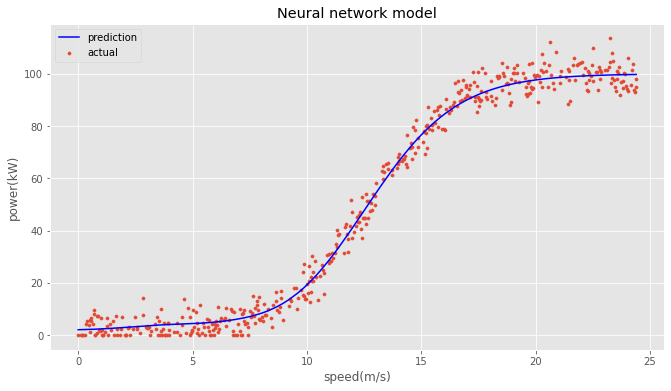

In [75]:
# Sort predicted power values for plotting
predict_nn = np.sort(nn_predict, axis=0)

# Sort speed test subset for plotting
A_Test_sort = np.sort(x_test, axis=0)

# Generate scatter plot and fitted line
plt.scatter(pp_clean.speed, pp_clean.power, label='actual', s=10)
plt.plot(A_Test_sort, predict_nn, label='prediction', color='b')

plt.title('Neural network model')
plt.xlabel('speed(m/s)')
plt.ylabel('power(kW)')
plt.legend()

In [76]:
final_model.save('final_model.h5')

## 6. Final model

***

The final predictive model, based on evaluation scores as generated above, is the last neural network model built above. As noted, wind speeds higher than the cut-out speed of 25.499 must return power values of 0kW. Similarly, wind speeds of less than 0.3 must also return values of 0kW in order to reflect the observations in the data set:

In [60]:
# Ouput first 10 rows of original data set
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


#### 6.1 Function to handle power values of 0kW

Below, I write a function called `model` which implements these characteristics into the final model. It takes an array of values as an argument. A for loop iterates over the array element by element, appending values of 0.0 if either of the conditions described above are met. All other speed values are passed through the neural network model built above, trained, tested and evaluated using k-fold cross validation. It returns a list of predicted values:

In [84]:
def model_nn(wind_speed):
    
    """
    Returns a list of predicted wind turbine power values from an array of wind speed inputs
    """
    
    # Initialise empty list
    power_prediction = []
    
    # Loop through wind speed array
    for i in range(len(wind_speed)):
        if wind_speed[i] >= 24.499 or wind_speed[i] < 0.3: # return 0.000 for values above 24.499 and below 0.3
            power_prediction.append(0.0)
        else:
            #baseline_model.predict(wind_speed[i])
            power_prediction.append(float(final_model.predict(wind_speed)[i])) # final predictive model
    
    return power_prediction

#### 6.2 Function demonstration

Below, I call the function passing the wind speed column from the original data set as an argument. The model has already been tested using k-fold cross validation. This is just to demonstrate that the function is working as it should. The predicted power values and speed values are added to a new dataframe [37]:

In [88]:
model_test = model_nn(pp.speed)

In [89]:
model_test

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.080313205718994,
 2.1006956100463867,
 2.115104913711548,
 2.1304774284362793,
 2.13826060295105,
 2.1462085247039795,
 2.154322624206543,
 2.1710400581359863,
 2.1884124279022217,
 2.1973440647125244,
 2.20643949508667,
 2.2156944274902344,
 2.234696388244629,
 2.2444424629211426,
 2.254347324371338,
 2.2850184440612793,
 2.2955620288848877,
 2.3062610626220703,
 2.317119836807251,
 2.328131914138794,
 2.3393023014068604,
 2.3506243228912354,
 2.3620996475219727,
 2.3855061531066895,
 2.4341044425964355,
 2.4466161727905273,
 2.4592745304107666,
 2.511296272277832,
 2.524641990661621,
 2.5660176277160645,
 2.593876600265503,
 2.651038885116577,
 2.6656131744384766,
 2.680300235748291,
 2.755277395248413,
 2.7859394550323486,
 2.801401376724243,
 2.8798861503601074,
 2.911769390106201,
 2.927799701690674,
 2.976210594177246,
 3.008707046508789,
 3.025010824203491,
 3.123359203338623,
 3.172672986984253,
 3.2225866317749023,
 3.238969326019287,
 3.320424

In [ ]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [ ]:
model = create_model()

In [ ]:
model.predict([14])

In [ ]:
# model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

In [ ]:
# plt.scatter(test['speed'], test['power'], label='actual', s=10)
# plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
# plt.legend()

In [ ]:
model.fit(x_train, y_train, epochs=500, batch_size=10)

In [ ]:
nn_predict = model.predict(x_test)

nn_predict.shape

In [ ]:
arr_sort = np.sort(nn_predict, axis=0)

In [ ]:
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(x_test, axis=0)

plt.scatter(x_train, y_train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [ ]:
model.summary()

In [ ]:
model.save('my_model.h5')

In [ ]:
model.predict([14])

In [ ]:


def some_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=some_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

In [30]:
# 1 layer, sigmoid, 100 epochs, lr=0.01 = 18.19
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std())) 

Standardized: -19.50 (7.73) MSE


In [35]:
# 1 layer, sigmoid, 300 epochs, lr=0.001 = 17.80, 17.35, 18.65
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -18.65 (6.02) MSE


In [37]:
# 1 layer, sigmoid, 300 epochs, lr=0.01 - 16.98, 18;00
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -18.00 (6.69) MSE


In [42]:
# 1 layer, relu, 100 epochs, lr=0.01- 17.79, 21.94, 48.13
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -45.10 (49.24) MSE


In [ ]:
# create_model (adding extra layer doesn't make a difference) - 17.43
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
create_model2 = create_model()

In [ ]:
create_model2.fit(x_train, y_train, epochs=100, batch_size=10)

In [ ]:
model.predict([99])

In [ ]:
baseline_model = baseline_model()
baseline_model.fit(x_train, y_train, epochs=100, batch_size=10)

In [ ]:
float(baseline_model.predict([14]))


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())

print(model2.score(A_Train, B_Train))

print(model2.score(A_Test, B_Test))
pred = model2.predict(A_Test)
pred = np.sort(pred, 0)

In [ ]:

from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())
model3.score(A_Train, B_Train)

model3.score(A_Test, B_Test)
pred2 = model3.predict(A_Test)
pred2 = np.sort(pred2, 0)

In [ ]:
# # Use model to make predictions
# pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, pred2, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[27] National Wind Watch; FAQ — Technology; https://www.wind-watch.org/faq-technology.php
[28] *Ibid.* <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>
[29] Grove, P; 5 Regression Loss Functions All Machine Learners Should Know; https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0 <br>
[30] Starmer, J; Neural Networks Part 1: Inside the Black Box; https://www.youtube.com/watch?v=CqOfi41LfDw <br>
[31] Brownlee, J; Regression Tutorial with the Keras Deep Learning Library in Python; https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/ <br>
[32] baeldung.com; The Difference Between Epoch and Iteration in Neural Networks; https://www.baeldung.com/cs/neural-networks-epoch-vs-iteration <br>
[33] Brownlee, J; Difference Between a Batch and an Epoch in a Neural Network; https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/ <br>
[34] Usman, M; Creating a Neural Network from Scratch in Python; https://stackabuse.com/creating-a-neural-network-from-scratch-in-python/ <br>
[35] *Ibid.* <br>
[36] *Ibid.* <br>
[37] *Ibid.* <br>
[38] Brownlee, J; A Gentle Introduction to k-fold Cross-Validation; https://machinelearningmastery.com/k-fold-cross-validation/ <br>
[39] Brownlee, J; Regression Tutorial with the Keras Deep Learning Library in Python;
https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/ <br>